# Overview

In [31]:
#Imports

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
import itertools
import warnings
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



warnings.filterwarnings('ignore')

WGS84 = "EPSG:4326"
PROJECTED_CRS = 26911  # Calgary UTM Zone 11N (accurate area + faster spatial join)


# Data Integration, Cleaning, and Feature Engineering

In [6]:
# Load Raw Data

df_incidents = pd.read_csv("Traffic_Incidents_20260216.csv")
df_climate = pd.read_csv("calgary_climate_daily_2016_2026.csv")
df_population = pd.read_csv("Historical_Community_Populations_20260216.csv")
df_boundaries = pd.read_csv("Community_District_Boundaries_20260216.csv")


In [7]:
# Climate Processing

numeric_cols = [
    "Mean Temp (°C)",
    "Total Snow (cm)",
    "Total Precip (mm)",
    "Spd of Max Gust (km/h)"
]

for col in numeric_cols:
    df_climate[col] = pd.to_numeric(df_climate[col], errors="coerce")

df_climate["Total Snow (cm)"] = df_climate["Total Snow (cm)"].fillna(0)
df_climate["Total Precip (mm)"] = df_climate["Total Precip (mm)"].fillna(0)

df_climate["Date/Time"] = pd.to_datetime(df_climate["Date/Time"])
df_climate["year_month"] = df_climate["Date/Time"].dt.to_period("M")

monthly_climate = (
    df_climate
    .groupby("year_month")
    .agg(
        avg_mean_temp=("Mean Temp (°C)", "mean"),
        total_snow_cm=("Total Snow (cm)", "sum"),
        total_precip_mm=("Total Precip (mm)", "sum"),
        snow_days=("Total Snow (cm)", lambda x: (x > 0).sum()),
        high_wind_days=("Spd of Max Gust (km/h)", lambda x: (x > 50).sum())
    )
    .reset_index()
)


In [8]:
# Spatial Boundaries

df_boundaries["geometry"] = df_boundaries["MULTIPOLYGON"].apply(wkt.loads)

gdf_boundaries = gpd.GeoDataFrame(
    df_boundaries,
    geometry="geometry",
    crs=WGS84
)

# Project for accurate area
gdf_boundaries = gdf_boundaries.to_crs(epsg=PROJECTED_CRS)

gdf_boundaries["area_km2"] = gdf_boundaries.area / 1_000_000

neighborhood_info = gdf_boundaries[["COMM_CODE", "NAME", "area_km2"]]

print("Boundary processing complete.")


Boundary processing complete.


In [9]:
# Incident Processing

df_incidents["START_DT"] = pd.to_datetime(df_incidents["START_DT"], errors='coerce')
df_incidents["MODIFIED_DT"] = pd.to_datetime(df_incidents["MODIFIED_DT"], errors='coerce')

# Drop rows with missing start dates
df_incidents = df_incidents.dropna(subset=["START_DT"])

# Create year_month column
df_incidents["year_month"] = df_incidents["START_DT"].dt.to_period("M")

# Severity scoring system
def severity_score(desc):
    """
    Classifies incidents based on description text.

    Severity scale:
        0 → normal traffic incident
        1 → multi-vehicle or two-vehicle incidents
        2 → incidents involving pedestrians or EMS on site
    Lane blockage and duration enhance severity.
    """
    desc = str(desc).lower()
    score = 0

    # High severity: pedestrian or EMS involvement
    if "pedestrian" in desc or "ems" in desc:
        score = 2

    # Medium severity: multi-vehicle or two-vehicle incidents
    elif "multi-vehicle" in desc or "two vehicle" in desc:
        score = 1

    # lane-blocking contribution
    if "blocking multiple lanes" in desc:
        score += 1
    elif re.search(r"blocking (left|right|middle|shoulder)", desc):
        score += 0.5

    return score

# Apply severity scoring
df_incidents["severity_score"] = df_incidents["DESCRIPTION"].apply(severity_score)

# Create binary "is_severe" flag

df_incidents["is_severe"] = (df_incidents["severity_score"] >= 1).astype(int)

print("Incident cleaning & enhanced severity scoring complete.")


Incident cleaning & enhanced severity scoring complete.


In [10]:
# Spatial Join

gdf_incidents = gpd.GeoDataFrame(
    df_incidents,
    geometry=gpd.points_from_xy(df_incidents.Longitude, df_incidents.Latitude),
    crs=WGS84
)

# Project incidents to match boundaries
gdf_incidents = gdf_incidents.to_crs(epsg=PROJECTED_CRS)

joined_incidents = gpd.sjoin(
    gdf_incidents,
    gdf_boundaries[["COMM_CODE", "geometry"]],
    how="inner",
    predicate="intersects"
)

incident_summary = (
    joined_incidents
    .groupby(["COMM_CODE", "year_month"])
    .agg(
        total_incidents=("id", "count"),
        severe_incidents=("severity_score", lambda x: (x > 0).sum()),
        avg_severity=("severity_score", "mean")
    )
    .reset_index()
)

print("Spatial join complete.")


Spatial join complete.


In [11]:
# Panel Construction


all_months = pd.period_range(
    df_incidents["year_month"].min(),
    df_incidents["year_month"].max(),
    freq="M"
)

all_comms = neighborhood_info["COMM_CODE"].unique()

base_panel = pd.DataFrame(
    list(itertools.product(all_comms, all_months)),
    columns=["COMM_CODE", "year_month"]
)

panel_df = (
    base_panel
    .merge(neighborhood_info, on="COMM_CODE", how="left")
    .merge(incident_summary, on=["COMM_CODE", "year_month"], how="left")
    .merge(monthly_climate, on="year_month", how="left")
)

panel_df.fillna(0, inplace=True)

print("Panel constructed.")


Panel constructed.


In [12]:
# Population Merge

df_population = df_population.copy()
df_population.columns = df_population.columns.str.strip().str.lower()

# Clean population column
df_population["population"] = (
    df_population["population"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

# Merge using COMM_CODE only
panel_df = panel_df.merge(
    df_population[["comm_code", "population"]],
    left_on="COMM_CODE",
    right_on="comm_code",
    how="left"
)

panel_df.drop(columns=["comm_code"], inplace=True)

# Remove zero or missing population areas
panel_df = panel_df[panel_df["population"] > 0]

print("Population merged.")


Population merged.


In [13]:
# Feature Engineering

panel_df["population_density"] = panel_df["population"] / panel_df["area_km2"]
panel_df["incidents_per_1000"] = (panel_df["total_incidents"] / panel_df["population"]) * 1000
panel_df["severe_per_1000"] = (panel_df["severe_incidents"] / panel_df["population"]) * 1000
panel_df["incidents_per_km2"] = panel_df["total_incidents"] / panel_df["area_km2"]

# Climate nonlinear features
panel_df["snow_squared"] = panel_df["total_snow_cm"] ** 2
panel_df["wind_snow_interaction"] = panel_df["total_snow_cm"] * panel_df["high_wind_days"]
panel_df["cold_days_flag"] = (panel_df["avg_mean_temp"] < -15).astype(int)

# Seasonality encoding
panel_df["month"] = panel_df["year_month"].dt.month
panel_df["sin_month"] = np.sin(2 * np.pi * panel_df["month"] / 12)
panel_df["cos_month"] = np.cos(2 * np.pi * panel_df["month"] / 12)

print("Advanced features created.")


Advanced features created.


In [14]:
# Lag & Rolling Features

panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

group = panel_df.groupby("COMM_CODE")

panel_df["lag_1"] = group["total_incidents"].shift(1)
panel_df["lag_3_avg"] = (
    group["total_incidents"]
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)

panel_df["rolling_std_6"] = (
    group["total_incidents"]
    .rolling(6)
    .std()
    .reset_index(level=0, drop=True)
)

panel_df.fillna(0, inplace=True)

print("Lag & rolling features added.")


Lag & rolling features added.


In [15]:
# Target Definition

# Absolute threshold
# panel_df["high_risk"] = (panel_df["severe_per_1000"] > 0.4).astype(int)
panel_df["high_risk"] = panel_df.groupby("year_month")["severe_per_1000"] \
                                .transform(lambda x: x > x.quantile(0.75)).astype(int)


print("Target variable created.")


Target variable created.


In [16]:
# Final Dataset

panel_df.rename(columns={"NAME": "community_name"}, inplace=True)

panel_df = panel_df.sort_values(["COMM_CODE", "year_month"]).reset_index(drop=True)

print("feature table complete.")
panel_df.head()


feature table complete.


,COMM_CODE,year_month,community_name,area_km2,total_incidents,severe_incidents,avg_severity,avg_mean_temp,total_snow_cm,total_precip_mm,...,snow_squared,wind_snow_interaction,cold_days_flag,month,sin_month,cos_month,lag_1,lag_3_avg,rolling_std_6,high_risk
0,ABB,2016-12,ABBEYDALE,1.70414,0.0,0.0,0.0,-10.316667,26.1,22.4,...,681.21,208.8,0,12,-2.449294e-16,1.000000e+00,0.0,0.000000,0.0,0
1,ABB,2017-01,ABBEYDALE,1.70414,0.0,0.0,0.0,-6.766667,14.7,10.5,...,216.09,88.2,0,1,5.000000e-01,8.660254e-01,0.0,0.000000,0.0,0
2,ABB,2017-02,ABBEYDALE,1.70414,0.0,0.0,0.0,-7.081481,35.8,30.8,...,1281.64,143.2,0,2,8.660254e-01,5.000000e-01,0.0,0.000000,0.0,0
3,ABB,2017-03,ABBEYDALE,1.70414,1.0,0.0,0.0,-2.412903,16.7,16.2,...,278.89,116.9,0,3,1.000000e+00,6.123234e-17,0.0,0.333333,0.0,0
4,ABB,2017-04,ABBEYDALE,1.70414,0.0,0.0,0.0,4.800000,16.6,67.3,...,275.56,49.8,0,4,8.660254e-01,-5.000000e-01,1.0,0.333333,0.0,0


In [17]:
# panel_df.to_csv('df_panel.csv', index=False)
# from google.colab import files
# files.download('df_panel.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Exploratory Data Analysis

In [18]:
#Sanity Check
# Basic structure
print("Shape:", panel_df.shape)
print("\nColumns:\n", panel_df.columns)

# Missing values summary
print("\nMissing Values:\n")
display(panel_df.isna().sum().sort_values(ascending=False))

# Quick distribution check
print("\nSummary Statistics:\n")
display(panel_df[["total_incidents", "severe_incidents", "severe_per_1000"]].describe())

# Check number of communities and months
print("\nUnique Communities:", panel_df["COMM_CODE"].nunique())
print("Unique Months:", panel_df["year_month"].nunique())


Shape: (21978, 27)

Columns:
 Index(['COMM_CODE', 'year_month', 'community_name', 'area_km2',
       'total_incidents', 'severe_incidents', 'avg_severity', 'avg_mean_temp',
       'total_snow_cm', 'total_precip_mm', 'snow_days', 'high_wind_days',
       'population', 'population_density', 'incidents_per_1000',
       'severe_per_1000', 'incidents_per_km2', 'snow_squared',
       'wind_snow_interaction', 'cold_days_flag', 'month', 'sin_month',
       'cos_month', 'lag_1', 'lag_3_avg', 'rolling_std_6', 'high_risk'],
      dtype='object')

Missing Values:



,0
COMM_CODE,0
year_month,0
community_name,0
area_km2,0
total_incidents,0
severe_incidents,0
avg_severity,0
avg_mean_temp,0
total_snow_cm,0
total_precip_mm,0



Summary Statistics:



,total_incidents,severe_incidents,severe_per_1000
count,21978.000000,21978.000000,21978.000000
mean,1.916143,0.821640,0.278852
std,2.635666,1.532836,1.854671
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,3.000000,1.000000,0.186706
max,32.000000,21.000000,86.956522



Unique Communities: 198
Unique Months: 111


The panel comprises 21,978 observations across 198 communities and 111 months. Descriptive statistics reveal that the distribution of severe_incidents is heavily right-skewed, with a mean of 0.82, a median of zero, and a 75th percentile of one. This indicates that the majority of community-month observations record no severe incidents, confirming that the dataset exhibits substantial zero-inflation. The absence of missing values across all 27 variables confirms that the panel construction and zero-imputation procedures were executed correctly.

### **City-Level Monthly Trends**

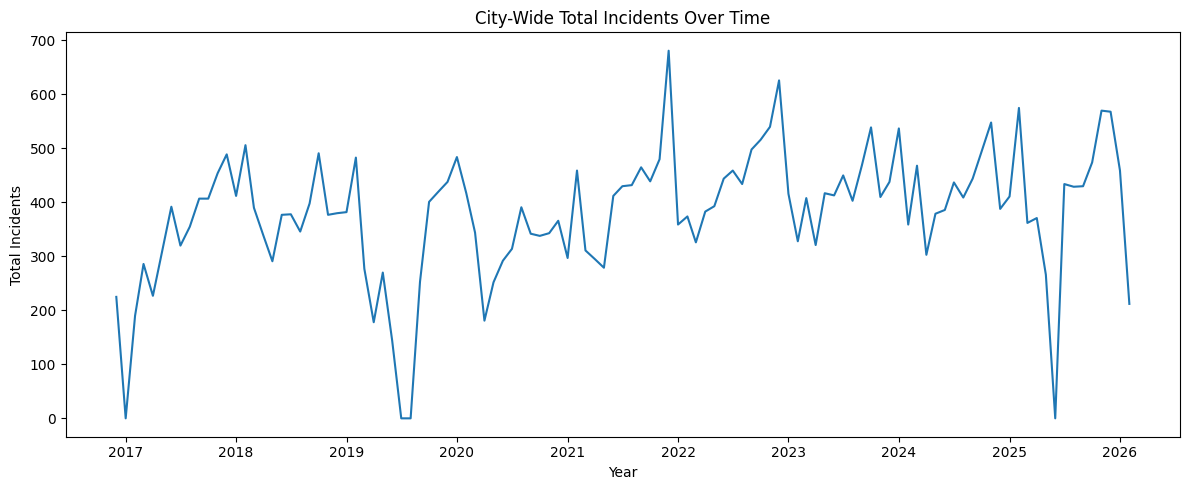

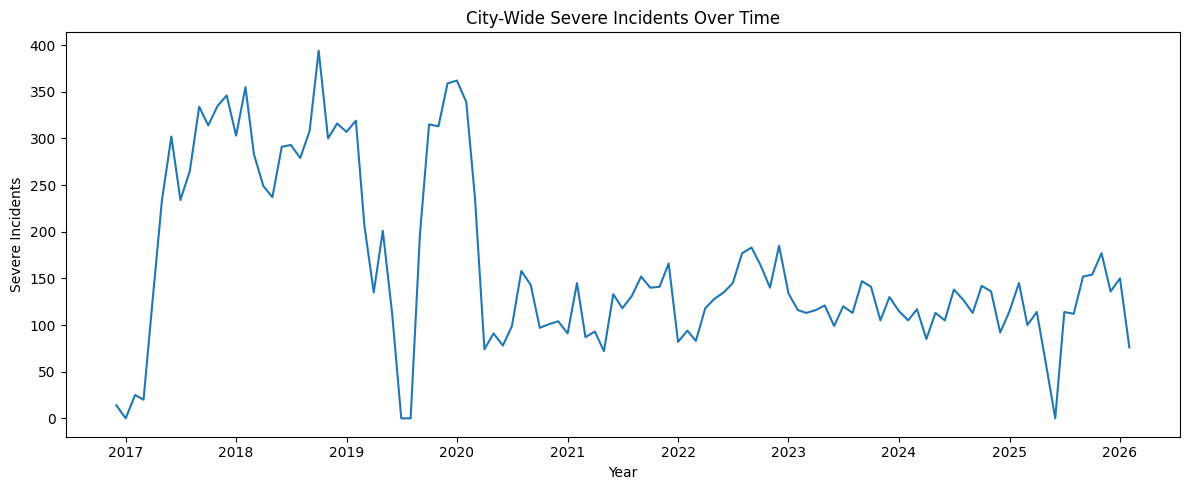

In [33]:
city_monthly = (
    panel_df
    .groupby("year_month")[["total_incidents", "severe_incidents"]]
    .sum()
    .reset_index()
)

# Convert Period → Timestamp (start of month)
city_monthly["year_month"] = city_monthly["year_month"].dt.to_timestamp()

# Plot Total Incidents
plt.figure(figsize=(12, 5))
plt.plot(city_monthly["year_month"], city_monthly["total_incidents"])

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("City-Wide Total Incidents Over Time")
plt.xlabel("Year")
plt.ylabel("Total Incidents")
plt.tight_layout()
plt.show()


# Plot Severe Incidents
plt.figure(figsize=(12, 5))
plt.plot(city_monthly["year_month"], city_monthly["severe_incidents"])

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("City-Wide Severe Incidents Over Time")
plt.xlabel("Year")
plt.ylabel("Severe Incidents")
plt.tight_layout()
plt.show()

The time series of total monthly incidents displays a pronounced upward trajectory from late 2016 through 2018–2019, during which monthly totals reach peaks of approximately 500–700 incidents. A sharp and near-complete collapse in incident volume is observed in early 2020, consistent with the reduction in vehicular activity associated with COVID-19 public health restrictions. Following this disruption, incident volumes partially recover but do not return to pre-pandemic levels, stabilizing in the range of 300–500 incidents per month from 2021 onward. A recurring within-year oscillation is evident throughout the series, indicative of seasonal periodicity.

The severe incidents series exhibits a structurally distinct pattern. While pre-2020 monthly severe incident counts reach peaks of 350–400, the post-2021 recovery plateaus at approximately 100–200 per month, a substantially lower ceiling than observed historically. Critically, this divergence between the total and severe incident series suggests that the compositional mix of incidents shifted following the pandemic period, with severe incidents comprising a smaller proportion of total incidents in subsequent years. This structural break carries implications for any model trained across the full historical range.

### **Seasonality Analysis**

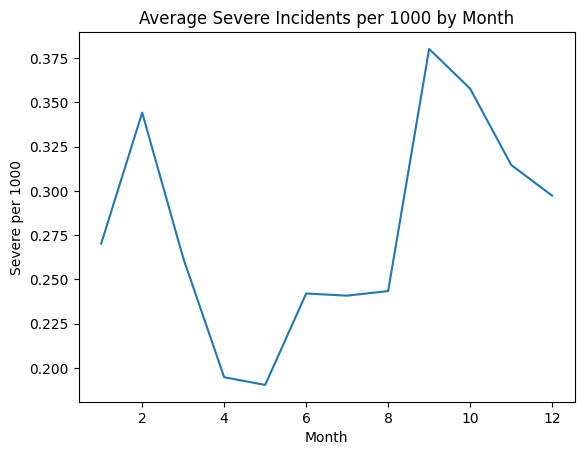

In [21]:
panel_df["month"] = panel_df["year_month"].dt.month

monthly_avg = (
    panel_df
    .groupby("month")["severe_per_1000"]
    .mean()
    .reset_index()
)

plt.figure()
plt.plot(monthly_avg["month"], monthly_avg["severe_per_1000"])
plt.title("Average Severe Incidents per 1000 by Month")
plt.xlabel("Month")
plt.ylabel("Severe per 1000")
plt.show()


The average severe_per_1000 by calendar month exhibits a bimodal pattern across the year, forming a discernible W-shape. Elevated rates are observed in February (approximately 0.325 per 1,000), followed by a trough in April (approximately 0.20), a secondary and more pronounced peak in August–September (approximately 0.375), and a gradual decline through the remainder of the year. Notably, the summer peak marginally exceeds the winter peak, which challenges the assumption that cold-weather conditions are the primary driver of severity. The spring nadir likely reflects a transitional period characterized by improved road conditions and lower pedestrian activity relative to summer months. This dual-cycle structure validates the inclusion of sinusoidal seasonality encodings (sin_month, cos_month), though a single harmonic may not fully capture the bimodal shape.

### **Community Risk Ranking**

In [22]:
community_risk = (
    panel_df
    .groupby("COMM_CODE")["severe_per_1000"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print("Top 10 High-Risk Communities:")
display(community_risk.head(10))


Top 10 High-Risk Communities:


,COMM_CODE,severe_per_1000
0,BVD,8.617313
1,CNS,8.174842
2,MEA,3.657793
3,MAF,1.358667
4,BRD,1.189440
5,SSW,1.131674
6,MPL,0.981363
7,WIN,0.953757
8,SOV,0.934666
9,GAG,0.835044


The average risk ranking reveals a pronounced separation between the top two communities and the remainder of the distribution. Belvedere (BVD) and Cornerstone (CNS) record mean severe_per_1000 values of 8.62 and 8.17, respectively, with the next-ranked community (MEA) at 3.66 and all subsequent communities below 1.36. This steep discontinuity is a methodological concern: both BVD and CNS are low-population suburban developments in which even a small absolute number of severe incidents produces an inflated per-capita rate.

### **Risk Consistency Analysis**

In [23]:
# Count months in top 25%
def top_quartile(x):
    return x > x.quantile(0.75)

panel_df["top_25_flag"] = (
    panel_df
    .groupby("year_month")["severe_per_1000"]
    .transform(top_quartile)
    .astype(int)
)

risk_consistency = (
    panel_df
    .groupby("COMM_CODE")["top_25_flag"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print("Communities Most Frequently High Risk:")
display(risk_consistency.head(10))


Communities Most Frequently High Risk:


,COMM_CODE,top_25_flag
0,BRD,104
1,DNC,103
2,WIN,97
3,MEA,91
4,ALB,89
5,VIS,85
6,MPL,84
7,SOV,84
8,SNA,82
9,REN,80


The risk consistency analysis offers a substantively different characterization of community risk. Bridgeland (BRD) and Downtown Commercial Core (DNC) appear in the top quartile in 104 and 103 of 111 months, respectively, a frequency of approximately 94–93%. Notably, neither BVD nor CNS appear among the ten most consistently high-risk communities. This distinction is analytically important: BVD and CNS are spike-driven outliers, whereas BRD, DNC, WIN, and MEA represent communities with persistent, structurally embedded risk. These two risk profiles are qualitatively different and should be treated as such in subsequent modeling.

### **Climate Correlation Matrix**

In [26]:
corr_cols = [
    "severe_per_1000",
    "total_snow_cm",
    "avg_mean_temp",
    "high_wind_days",
    "population_density",
    "incidents_per_1000"
]

correlation_matrix = panel_df[corr_cols].corr()

print("Correlation Matrix:")
display(correlation_matrix)


Correlation Matrix:


,severe_per_1000,total_snow_cm,avg_mean_temp,high_wind_days,population_density,incidents_per_1000
severe_per_1000,1.000000,2.382233e-02,-1.411373e-02,-1.194962e-02,-1.121117e-01,0.536968
total_snow_cm,0.023822,1.000000e+00,-6.900959e-01,-2.407732e-01,1.972690e-17,0.011295
avg_mean_temp,-0.014114,-6.900959e-01,1.000000e+00,1.210642e-01,-1.447387e-16,-0.009729
high_wind_days,-0.011950,-2.407732e-01,1.210642e-01,1.000000e+00,-1.950643e-16,-0.006065
population_density,-0.112112,1.972690e-17,-1.447387e-16,-1.950643e-16,1.000000e+00,-0.164456
incidents_per_1000,0.536968,1.129498e-02,-9.729435e-03,-6.064588e-03,-1.644555e-01,1.000000


The correlation matrix demonstrates that weather-related variables exhibit negligible linear association with severe_per_1000. The Pearson correlation coefficients are 0.024 for total snowfall, -0.014 for mean temperature, and -0.012 for high wind days — none of which are meaningfully different from zero. The strongest predictor of severe_per_1000 is incidents_per_1000 at 0.537, a relationship that is largely tautological, as the volume of total incidents is a direct antecedent of severe incident counts.

Population density returns a correlation of -0.112 with severe_per_1000. Rather than reflecting a genuine inverse relationship between urban density and traffic risk, this is more plausibly attributable to a denominator artifact: high-density communities have large populations that suppress the per-1000 rate even when absolute incident counts are elevated. The near-zero weather correlations suggest that climatic variables may not be primary drivers of severity rates at this level of temporal and spatial aggregation, and that any predictive contribution from weather features will likely operate through nonlinear or interaction pathways rather than direct linear effects.

### **Density vs Severity Relationship**

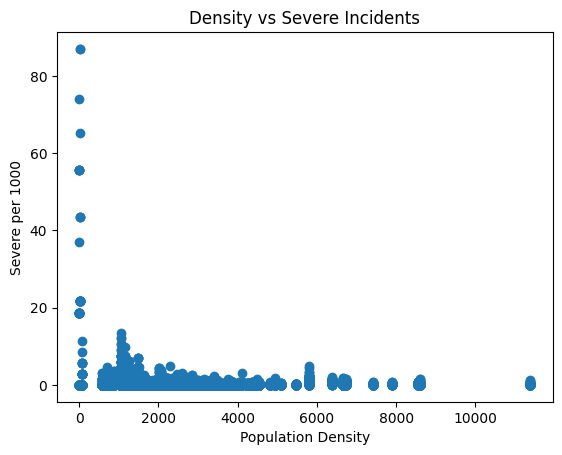

In [27]:
plt.figure()
plt.scatter(panel_df["population_density"], panel_df["severe_per_1000"])
plt.xlabel("Population Density")
plt.ylabel("Severe per 1000")
plt.title("Density vs Severe Incidents")
plt.show()


The scatter plot of severe_per_1000 against population density reveals that the overwhelming majority of observations cluster near zero along the horizontal axis, across the full range of population density values (0 to approximately 10,000 persons per km²). The only notable departures from this baseline are a small number of observations in the upper-left quadrant communities of low population density recording extreme severity rates of 20–80+ per 1,000. These observations correspond exclusively to BVD and CNS. No discernible linear or threshold relationship between population density and severity rates is observable for the remaining 196 communities. The scatter plot therefore does not support the hypothesis of a structural density-risk relationship; rather, it illustrates the distorting influence of small population denominators on the rate metric.

### **High-Risk Label Diagnostics**

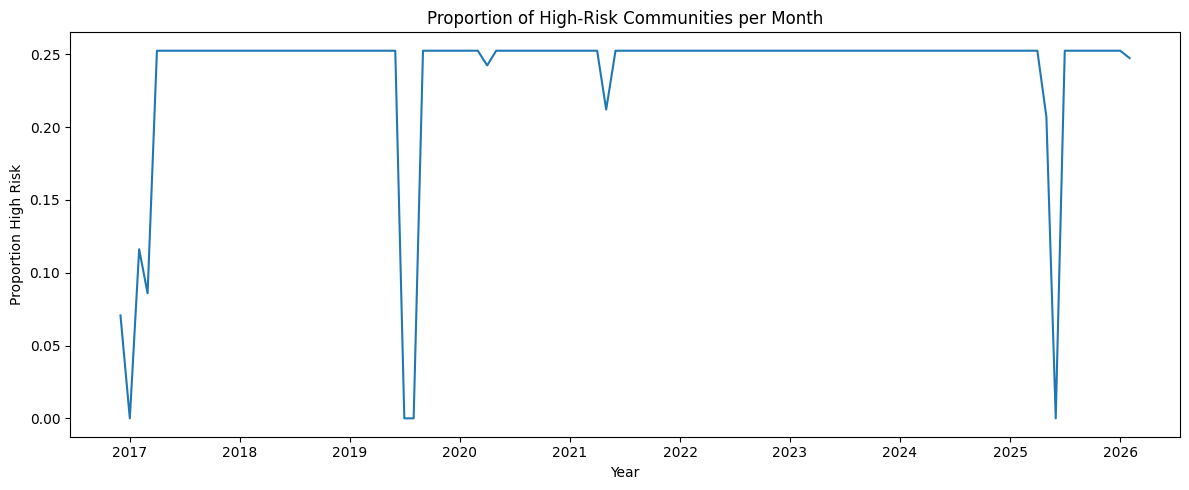

In [32]:
monthly_balance["year_month"] = monthly_balance["year_month"].dt.to_timestamp()

plt.figure(figsize=(12, 5))
plt.plot(monthly_balance["year_month"], monthly_balance["high_risk"])

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("Proportion of High-Risk Communities per Month")
plt.xlabel("Year")
plt.ylabel("Proportion High Risk")
plt.tight_layout()
plt.show()

The time series of the monthly proportion of communities classified as high-risk reveals considerable instability in the high_risk label. While the proportion generally oscillates between 0.10 and 0.25, several months exhibit sharp drops to near-zero. This instability arises from the relative definition of the label: communities are classified as high-risk if their severe_per_1000 exceeds the 75th percentile within each month. In months where incident activity is broadly suppressed, such as during the 2020 lockdown period or other low-activity months, the 75th percentile threshold itself approaches zero, and consequently very few communities satisfy the criterion. The label is therefore not temporally consistent: membership in the high-risk category reflects different absolute levels of risk depending on the month in which the classification is applied. This inconsistency may introduce noise into any supervised classification model trained on this target variable.

### **Outlier Detection**

In [29]:
print("Extreme Severe per 1000 Values:")
display(panel_df.sort_values("severe_per_1000", ascending=False).head(10))

print("Zero-heavy communities:")
zero_summary = (
    panel_df
    .groupby("COMM_CODE")["severe_incidents"]
    .sum()
    .sort_values()
    .reset_index()
)

display(zero_summary.head(10))


Extreme Severe per 1000 Values:


,COMM_CODE,year_month,community_name,area_km2,total_incidents,severe_incidents,avg_severity,avg_mean_temp,total_snow_cm,total_precip_mm,...,wind_snow_interaction,cold_days_flag,month,sin_month,cos_month,lag_1,lag_3_avg,rolling_std_6,high_risk,top_25_flag
2289,BVD,2022-09,BELVEDERE,3.668411,4.0,4.0,1.25,15.143333,0.0,10.8,...,0.0,0,9,-1.000000e+00,-1.836970e-16,2.0,2.333333,1.378405,1,1
2242,BVD,2018-10,BELVEDERE,3.668411,4.0,4.0,1.00,4.093333,48.4,48.2,...,242.0,0,10,-8.660254e-01,5.000000e-01,1.0,2.333333,1.505545,1,1
3901,CNS,2018-04,CORNERSTONE,7.646115,4.0,4.0,1.00,1.586667,24.8,29.7,...,148.8,0,4,8.660254e-01,-5.000000e-01,1.0,2.666667,1.211060,1,1
2258,BVD,2020-02,BELVEDERE,3.668411,3.0,3.0,1.00,-3.303448,21.5,19.9,...,236.5,0,2,8.660254e-01,5.000000e-01,1.0,1.666667,1.032796,1,1
3892,CNS,2017-07,CORNERSTONE,7.646115,3.0,3.0,1.00,19.351724,0.0,55.5,...,0.0,0,7,-5.000000e-01,-8.660254e-01,3.0,2.000000,1.169045,1,1
3897,CNS,2017-12,CORNERSTONE,7.646115,3.0,3.0,1.00,-7.403448,32.2,30.9,...,161.0,0,12,-2.449294e-16,1.000000e+00,1.0,1.666667,1.224745,1,1
3907,CNS,2018-10,CORNERSTONE,7.646115,3.0,3.0,1.00,4.093333,48.4,48.2,...,242.0,0,10,-8.660254e-01,5.000000e-01,1.0,2.000000,1.211060,1,1
3912,CNS,2019-03,CORNERSTONE,7.646115,3.0,3.0,1.00,-2.516129,8.2,7.2,...,24.6,0,3,1.000000e+00,6.123234e-17,3.0,2.000000,1.329160,1,1
3923,CNS,2020-02,CORNERSTONE,7.646115,3.0,3.0,1.00,-3.303448,21.5,19.9,...,236.5,0,2,8.660254e-01,5.000000e-01,1.0,1.333333,1.095445,1,1
2274,BVD,2021-06,BELVEDERE,3.668411,4.0,2.0,0.75,17.122222,0.0,30.3,...,0.0,0,6,1.224647e-16,-1.000000e+00,2.0,2.333333,1.366260,1,1


Zero-heavy communities:


,COMM_CODE,severe_incidents
0,BEL,0.0
1,DRN,0.0
2,ROX,1.0
3,RID,1.0
4,NHU,4.0
5,CHK,5.0
6,GRE,5.0
7,DRG,5.0
8,POI,5.0
9,RMT,6.0


The ten observations with the highest severe_per_1000 values are drawn entirely from BVD (Belvedere) and CNS (Cornerstone). In each case, the underlying absolute count of severe incidents is modest, typically three to four incidents per month, but the small residential populations of these communities yield extreme per-capita rates, with a maximum of 86.96 per 1,000 observed in Belvedere during September 2022. These observations are not indicative of genuine community-level hazard at scale, but rather reflect a measurement artifact inherent in the rate normalization.

At the opposite extreme, the zero-summary table identifies communities such as BEL and DRN as having accumulated zero severe incidents across the entire study period. Communities of this nature offer no predictive signal for a severity-focused model and may warrant exclusion or separate treatment. Collectively, these findings suggest that log-transformation or winsorization of severe_per_1000 prior to modeling is advisable to mitigate the influence of extreme values on model training.

Temporal Dependence (Lag Check)

In [30]:
panel_df = panel_df.sort_values(["COMM_CODE", "year_month"])

panel_df["lag_severe"] = (
    panel_df
    .groupby("COMM_CODE")["severe_per_1000"]
    .shift(1)
)

print("Correlation between current and lagged severity:")
print(panel_df[["severe_per_1000", "lag_severe"]].corr())


Correlation between current and lagged severity:
                 severe_per_1000  lag_severe
severe_per_1000         1.000000    0.343971
lag_severe              0.343971    1.000000


### **Overall Assessment**

Taken together, the exploratory analysis reveals several findings of methodological significance. The dataset is heavily zero-inflated, with incident severity concentrated in a small number of communities and months. Weather variables demonstrate negligible linear association with severity rates at the monthly community level, suggesting that climatic factors are not primary structural drivers. A persistent post-2020 structural break in severe incident volumes indicates that pre- and post-pandemic data may reflect different underlying processes. The per-1000 rate metric is susceptible to small-population distortion, and both the target variable definition and outlier treatment strategy should be addressed prior to model development. A subset of approximately five to ten communities exhibit chronic, structurally embedded high-risk profiles that are likely to be highly predictive in any subsequent classification framework.